In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7212 - acc: 0.1027
Epoch 00001: val_loss improved from inf to 2.89868, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_1_conv_checkpoint/001-2.8987.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 3.7212 - acc: 0.1027 - val_loss: 2.8987 - val_acc: 0.1123
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3767 - acc: 0.3100
Epoch 00002: val_loss did not improve from 2.89868
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.3768 - acc: 0.3100 - val_loss: 3.3952 - val_acc: 0.1174
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9549 - acc: 0.4139
Epoch 00003: val_loss did not improve from 2.89868
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.9549 - acc: 0.4139 - val_loss: 3.6

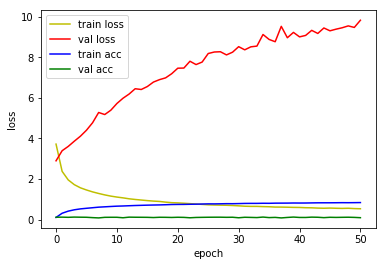

4815/4815 [==============================] - 2s 436us/sample - loss: 2.8910 - acc: 0.1011
Loss: 2.890962796196388 Accuracy: 0.101142265

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1808 - acc: 0.2094
Epoch 00001: val_loss improved from inf to 2.56597, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_2_conv_checkpoint/001-2.5660.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.1808 - acc: 0.2093 - val_loss: 2.5660 - val_acc: 0.2784
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2559 - acc: 0.4057
Epoch 00002: val_loss did not improve from 2.56597
36805/36805 [==============================] - 71s 2ms/sample - loss: 2.2558 - acc: 0.4057 - val_loss: 2.9516 - val_acc: 0.2884
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8201 - acc: 0.5063
Epoch 00003: val_loss did not improve from 2.56597
36805/36805 [====

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4123 - acc: 0.8972
Epoch 00030: val_loss did not improve from 2.56597
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.4123 - acc: 0.8972 - val_loss: 6.6565 - val_acc: 0.3205
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4048 - acc: 0.9002
Epoch 00031: val_loss did not improve from 2.56597
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.4048 - acc: 0.9002 - val_loss: 5.0533 - val_acc: 0.4165
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4008 - acc: 0.9020
Epoch 00032: val_loss did not improve from 2.56597
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.4008 - acc: 0.9020 - val_loss: 7.6910 - val_acc: 0.3014
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4040 - acc: 0.9051
Epoch 00033: val_loss did not improve from 2.56597
36805/36805 [===========

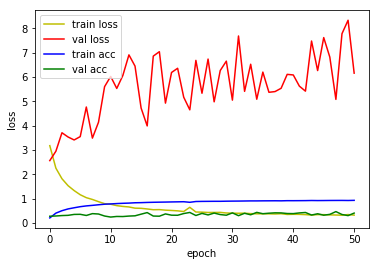

4815/4815 [==============================] - 4s 736us/sample - loss: 2.6459 - acc: 0.2569
Loss: 2.645937170838765 Accuracy: 0.2569055

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6339 - acc: 0.2808
Epoch 00001: val_loss improved from inf to 1.95504, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_3_conv_checkpoint/001-1.9550.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.6338 - acc: 0.2808 - val_loss: 1.9550 - val_acc: 0.3899
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8317 - acc: 0.4734
Epoch 00002: val_loss improved from 1.95504 to 1.80777, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_3_conv_checkpoint/002-1.8078.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.8315 - acc: 0.4734 - val_loss: 1.8078 - val_acc: 0.4878
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3673 - acc: 0.8882
Epoch 00029: val_loss did not improve from 1.72068
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.3674 - acc: 0.8882 - val_loss: 1.9258 - val_acc: 0.6268
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3591 - acc: 0.8913
Epoch 00030: val_loss did not improve from 1.72068
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.3591 - acc: 0.8913 - val_loss: 2.3022 - val_acc: 0.5898
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3483 - acc: 0.8957
Epoch 00031: val_loss did not improve from 1.72068
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.3484 - acc: 0.8956 - val_loss: 2.1724 - val_acc: 0.6112
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3576 - acc: 0.8927
Epoch 00032: val_loss did not improve from 1.72068
36805/36805 [===========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2378 - acc: 0.9318
Epoch 00059: val_loss did not improve from 1.72068
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2379 - acc: 0.9318 - val_loss: 2.8542 - val_acc: 0.5775
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2831 - acc: 0.9253
Epoch 00060: val_loss did not improve from 1.72068
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2831 - acc: 0.9253 - val_loss: 2.5257 - val_acc: 0.6238
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2414 - acc: 0.9308
Epoch 00061: val_loss did not improve from 1.72068
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2414 - acc: 0.9308 - val_loss: 2.5976 - val_acc: 0.6203
Epoch 62/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2302 - acc: 0.9337
Epoch 00062: val_loss did not improve from 1.72068
36805/36805 [===========

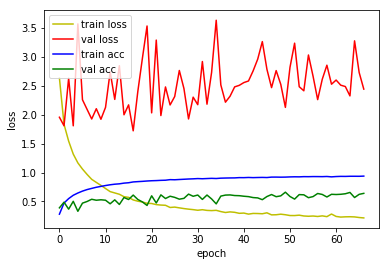

4815/4815 [==============================] - 4s 853us/sample - loss: 1.9468 - acc: 0.5624
Loss: 1.9468042068639897 Accuracy: 0.56240916

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5100 - acc: 0.3020
Epoch 00001: val_loss improved from inf to 1.87417, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_4_conv_checkpoint/001-1.8742.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 2.5098 - acc: 0.3020 - val_loss: 1.8742 - val_acc: 0.4086
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7434 - acc: 0.4854
Epoch 00002: val_loss improved from 1.87417 to 1.64209, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_4_conv_checkpoint/002-1.6421.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.7433 - acc: 0.4854 - val_loss: 1.6421 - val_acc: 0.5099
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2879 - acc: 0.9055
Epoch 00058: val_loss did not improve from 1.06568
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2879 - acc: 0.9055 - val_loss: 1.3117 - val_acc: 0.7119
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2868 - acc: 0.9071
Epoch 00059: val_loss did not improve from 1.06568
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2869 - acc: 0.9071 - val_loss: 1.5112 - val_acc: 0.6841
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2847 - acc: 0.9084
Epoch 00060: val_loss did not improve from 1.06568
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2847 - acc: 0.9084 - val_loss: 1.2173 - val_acc: 0.7305
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2818 - acc: 0.9069
Epoch 00061: val_loss did not improve from 1.06568
36805/36805 [===========

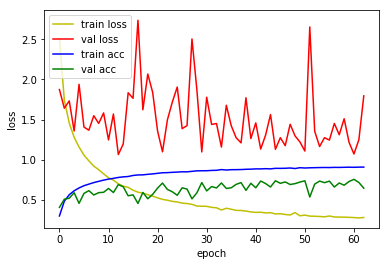

4815/4815 [==============================] - 4s 901us/sample - loss: 1.1870 - acc: 0.6550
Loss: 1.1869688870379487 Accuracy: 0.65503633

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5031 - acc: 0.3133
Epoch 00001: val_loss improved from inf to 1.72824, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_5_conv_checkpoint/001-1.7282.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 2.5028 - acc: 0.3133 - val_loss: 1.7282 - val_acc: 0.4817
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7528 - acc: 0.4869
Epoch 00002: val_loss did not improve from 1.72824
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.7530 - acc: 0.4868 - val_loss: 2.2248 - val_acc: 0.4365
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4672 - acc: 0.5689
Epoch 00003: val_loss did not improve from 1.72824
36805/36805 [====

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5026 - acc: 0.8429
Epoch 00029: val_loss did not improve from 0.87002
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.5026 - acc: 0.8429 - val_loss: 1.8376 - val_acc: 0.5761
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4950 - acc: 0.8468
Epoch 00030: val_loss did not improve from 0.87002
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4951 - acc: 0.8468 - val_loss: 1.2022 - val_acc: 0.7004
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4785 - acc: 0.8492
Epoch 00031: val_loss did not improve from 0.87002
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4785 - acc: 0.8492 - val_loss: 1.2611 - val_acc: 0.6914
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4772 - acc: 0.8490
Epoch 00032: val_loss did not improve from 0.87002
36805/36805 [===========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3291 - acc: 0.8930
Epoch 00059: val_loss did not improve from 0.87002
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3290 - acc: 0.8930 - val_loss: 1.2933 - val_acc: 0.7056
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3284 - acc: 0.8948
Epoch 00060: val_loss did not improve from 0.87002
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3285 - acc: 0.8948 - val_loss: 1.3354 - val_acc: 0.6974
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3307 - acc: 0.8940
Epoch 00061: val_loss did not improve from 0.87002
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3309 - acc: 0.8940 - val_loss: 1.7960 - val_acc: 0.6231
Epoch 62/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3209 - acc: 0.8972
Epoch 00062: val_loss did not improve from 0.87002
36805/36805 [===========

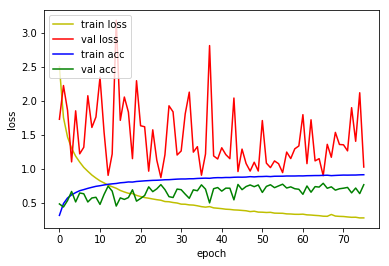

4815/4815 [==============================] - 4s 927us/sample - loss: 1.0354 - acc: 0.7146
Loss: 1.0353753791172309 Accuracy: 0.71464175

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6384 - acc: 0.2736
Epoch 00001: val_loss improved from inf to 1.78613, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_6_conv_checkpoint/001-1.7861.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 2.6385 - acc: 0.2735 - val_loss: 1.7861 - val_acc: 0.4503
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8372 - acc: 0.4567
Epoch 00002: val_loss improved from 1.78613 to 1.32294, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_6_conv_checkpoint/002-1.3229.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.8373 - acc: 0.4567 - val_loss: 1.3229 - val_acc: 0.5970
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5699 - acc: 0.8270
Epoch 00027: val_loss did not improve from 0.80785
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.5699 - acc: 0.8270 - val_loss: 0.8935 - val_acc: 0.7391
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5575 - acc: 0.8301
Epoch 00028: val_loss did not improve from 0.80785
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.5575 - acc: 0.8301 - val_loss: 0.9571 - val_acc: 0.7368
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5476 - acc: 0.8334
Epoch 00029: val_loss did not improve from 0.80785
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.5477 - acc: 0.8334 - val_loss: 1.7149 - val_acc: 0.5896
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5389 - acc: 0.8359
Epoch 00030: val_loss did not improve from 0.80785
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3776 - acc: 0.8810
Epoch 00056: val_loss did not improve from 0.66832
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3776 - acc: 0.8810 - val_loss: 0.8314 - val_acc: 0.7750
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3644 - acc: 0.8858
Epoch 00057: val_loss did not improve from 0.66832
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3644 - acc: 0.8858 - val_loss: 0.8193 - val_acc: 0.7771
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3724 - acc: 0.8840
Epoch 00058: val_loss did not improve from 0.66832
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3723 - acc: 0.8840 - val_loss: 0.6930 - val_acc: 0.8027
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3689 - acc: 0.8849
Epoch 00059: val_loss did not improve from 0.66832
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2742 - acc: 0.9129
Epoch 00086: val_loss did not improve from 0.66832
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2744 - acc: 0.9128 - val_loss: 0.7271 - val_acc: 0.8025
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2809 - acc: 0.9105
Epoch 00087: val_loss did not improve from 0.66832
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2809 - acc: 0.9105 - val_loss: 1.3956 - val_acc: 0.7030
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2733 - acc: 0.9130
Epoch 00088: val_loss did not improve from 0.66832
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2734 - acc: 0.9130 - val_loss: 0.8930 - val_acc: 0.7815
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2749 - acc: 0.9108
Epoch 00089: val_loss did not improve from 0.66832
36805/36805 [===========

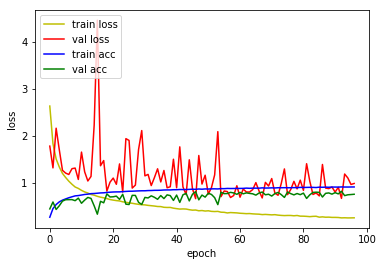

4815/4815 [==============================] - 5s 963us/sample - loss: 0.8086 - acc: 0.7763
Loss: 0.8085539792557 Accuracy: 0.776324

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8602 - acc: 0.2234
Epoch 00001: val_loss improved from inf to 1.85994, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_7_conv_checkpoint/001-1.8599.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 2.8601 - acc: 0.2234 - val_loss: 1.8599 - val_acc: 0.3925
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9914 - acc: 0.4022
Epoch 00002: val_loss improved from 1.85994 to 1.63852, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_7_conv_checkpoint/002-1.6385.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.9913 - acc: 0.4022 - val_loss: 1.6385 - val_acc: 0.4757
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2933 - acc: 0.9120
Epoch 00055: val_loss did not improve from 0.42677
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2933 - acc: 0.9120 - val_loss: 0.4469 - val_acc: 0.8691
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2814 - acc: 0.9132
Epoch 00056: val_loss did not improve from 0.42677
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2814 - acc: 0.9131 - val_loss: 0.5392 - val_acc: 0.8551
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2805 - acc: 0.9146
Epoch 00057: val_loss did not improve from 0.42677
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2806 - acc: 0.9145 - val_loss: 1.3531 - val_acc: 0.7002
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2726 - acc: 0.9161
Epoch 00058: val_loss did not improve from 0.42677
36805/36805 [===========

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1273 - acc: 0.9590
Epoch 00114: val_loss did not improve from 0.37092
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1273 - acc: 0.9590 - val_loss: 0.6121 - val_acc: 0.8428
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1153 - acc: 0.9643
Epoch 00115: val_loss did not improve from 0.37092
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1153 - acc: 0.9643 - val_loss: 0.6045 - val_acc: 0.8602
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1194 - acc: 0.9622
Epoch 00116: val_loss did not improve from 0.37092
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1194 - acc: 0.9622 - val_loss: 0.5212 - val_acc: 0.8707
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1232 - acc: 0.9618
Epoch 00117: val_loss did not improve from 0.37092
36805/36805 [=======

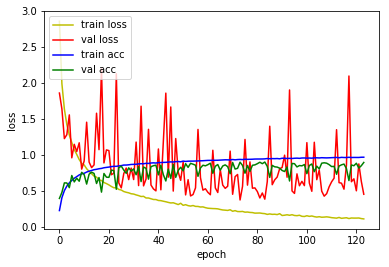

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4881 - acc: 0.8617
Loss: 0.4880750718889207 Accuracy: 0.86168224

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9302 - acc: 0.2124
Epoch 00001: val_loss improved from inf to 1.64914, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_8_conv_checkpoint/001-1.6491.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 2.9302 - acc: 0.2124 - val_loss: 1.6491 - val_acc: 0.4990
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0708 - acc: 0.3819
Epoch 00002: val_loss improved from 1.64914 to 1.41472, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_8_conv_checkpoint/002-1.4147.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.0708 - acc: 0.3819 - val_loss: 1.4147 - val_acc: 0.5775
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3219 - acc: 0.9051
Epoch 00026: val_loss did not improve from 0.34532
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3219 - acc: 0.9051 - val_loss: 0.3870 - val_acc: 0.8849
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3210 - acc: 0.9052
Epoch 00027: val_loss did not improve from 0.34532
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3210 - acc: 0.9051 - val_loss: 0.4889 - val_acc: 0.8623
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3067 - acc: 0.9105
Epoch 00028: val_loss did not improve from 0.34532
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3068 - acc: 0.9104 - val_loss: 0.6628 - val_acc: 0.8029
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2999 - acc: 0.9113
Epoch 00029: val_loss did not improve from 0.34532
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0757 - acc: 0.9763
Epoch 00083: val_loss did not improve from 0.22076
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0757 - acc: 0.9763 - val_loss: 0.3422 - val_acc: 0.9057
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0806 - acc: 0.9746
Epoch 00084: val_loss did not improve from 0.22076
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0806 - acc: 0.9746 - val_loss: 0.3085 - val_acc: 0.9217
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0779 - acc: 0.9762
Epoch 00085: val_loss did not improve from 0.22076
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0779 - acc: 0.9762 - val_loss: 0.2895 - val_acc: 0.9269
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0790 - acc: 0.9749
Epoch 00086: val_loss did not improve from 0.22076
36805/36805 [===========

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9862
Epoch 00113: val_loss did not improve from 0.22076
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0455 - acc: 0.9862 - val_loss: 0.3030 - val_acc: 0.9248
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9861
Epoch 00114: val_loss did not improve from 0.22076
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0461 - acc: 0.9861 - val_loss: 0.3054 - val_acc: 0.9243
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9836
Epoch 00115: val_loss did not improve from 0.22076
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0545 - acc: 0.9836 - val_loss: 0.3788 - val_acc: 0.9161
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9832
Epoch 00116: val_loss did not improve from 0.22076
36805/36805 [=======

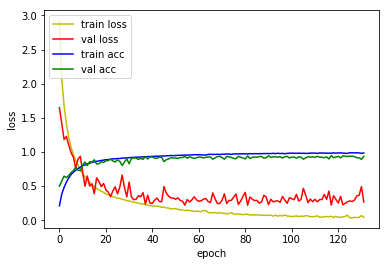

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2966 - acc: 0.9229
Loss: 0.2966239247552331 Accuracy: 0.92294914

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7070 - acc: 0.2652
Epoch 00001: val_loss improved from inf to 1.53920, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_9_conv_checkpoint/001-1.5392.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 2.7071 - acc: 0.2652 - val_loss: 1.5392 - val_acc: 0.5181
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7021 - acc: 0.4907
Epoch 00002: val_loss improved from 1.53920 to 1.18862, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_BN_9_conv_checkpoint/002-1.1886.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 1.7021 - acc: 0.4907 - val_loss: 1.1886 - val_acc: 0.6280
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1618 - acc: 0.9506
Epoch 00025: val_loss did not improve from 0.19321
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.1618 - acc: 0.9506 - val_loss: 0.2153 - val_acc: 0.9369
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1513 - acc: 0.9557
Epoch 00026: val_loss did not improve from 0.19321
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.1514 - acc: 0.9557 - val_loss: 0.2439 - val_acc: 0.9299
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1469 - acc: 0.9577
Epoch 00027: val_loss did not improve from 0.19321
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.1469 - acc: 0.9578 - val_loss: 0.2414 - val_acc: 0.9290
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1383 - acc: 0.9586
Epoch 00028: val_loss did not improve from 0.19321
36805/36805 [===========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9829
Epoch 00054: val_loss did not improve from 0.17431
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0556 - acc: 0.9829 - val_loss: 0.1790 - val_acc: 0.9534
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9880
Epoch 00055: val_loss did not improve from 0.17431
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0401 - acc: 0.9880 - val_loss: 0.1783 - val_acc: 0.9502
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9860
Epoch 00056: val_loss did not improve from 0.17431
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0467 - acc: 0.9860 - val_loss: 0.2113 - val_acc: 0.9443
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9873
Epoch 00057: val_loss did not improve from 0.17431
36805/36805 [===========

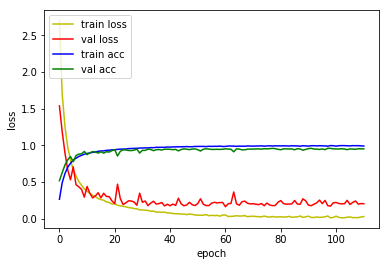

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2364 - acc: 0.9441
Loss: 0.2364354925940001 Accuracy: 0.9441329



In [10]:
base = '1D_CNN_custom_tanh_DO_075_DO_BN'

for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_tanh_DO_075_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_075_DO_BN_1_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0   

4815/4815 [==============================] - 4s 837us/sample - loss: 1.1870 - acc: 0.6550
Loss: 1.1869688870379487 Accuracy: 0.65503633

1D_CNN_custom_tanh_DO_075_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)

4815/4815 [==============================] - 5s 941us/sample - loss: 0.4881 - acc: 0.8617
Loss: 0.4880750718889207 Accuracy: 0.86168224

1D_CNN_custom_tanh_DO_075_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2364 - acc: 0.9441
Loss: 0.2364354928876133 Accuracy: 0.9441329


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_075_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 2.1484 - acc: 0.5917
Loss: 2.148403761121962 Accuracy: 0.5916926

1D_CNN_custom_tanh_DO_075_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.5309 - acc: 0.8665
Loss: 0.5308669363350635 Accuracy: 0.866459

1D_CNN_custom_tanh_DO_075_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2644 - acc: 0.9433
Loss: 0.26436952109393486 Accuracy: 0.94330215
